<a href="https://www.kaggle.com/code/chadmottershead/cleaning-and-analyzing-tree-planting-data?scriptVersionId=152817438" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Cleaning, Formatting, and Analyzing Tree Planting Program Data

I work as an administrator for a volunteer tree planting program for my local municipality. One of the major challenges of the program in past years has been accurately tracking what types of plants get planted where over the course of each planting season. In this project, I took data from many different sources and compiled them into a usable database format for analysis.

# Project One

Until recently, the organization I work in has has two separate teams tracking plant numbers in a variety of Google Sheets documents. Normally, the plant tracking sheets that are submitted by field workers (in data as "blank-plant-tracker-template") are used to populate the inventory tracking sheet. For this reason, I initially thought I would be able to reliably use the data from the inventory sheet to calculate the totals of each species planted.

The original Inventory sheet contains information that is not sensitive or personal, but borders on personally identifiable and really has no relevancy for the manipulation I'm doing here, so I removed it.

As you will see, the data in the inventory spreadsheet is stored in a pivoted format, like this:
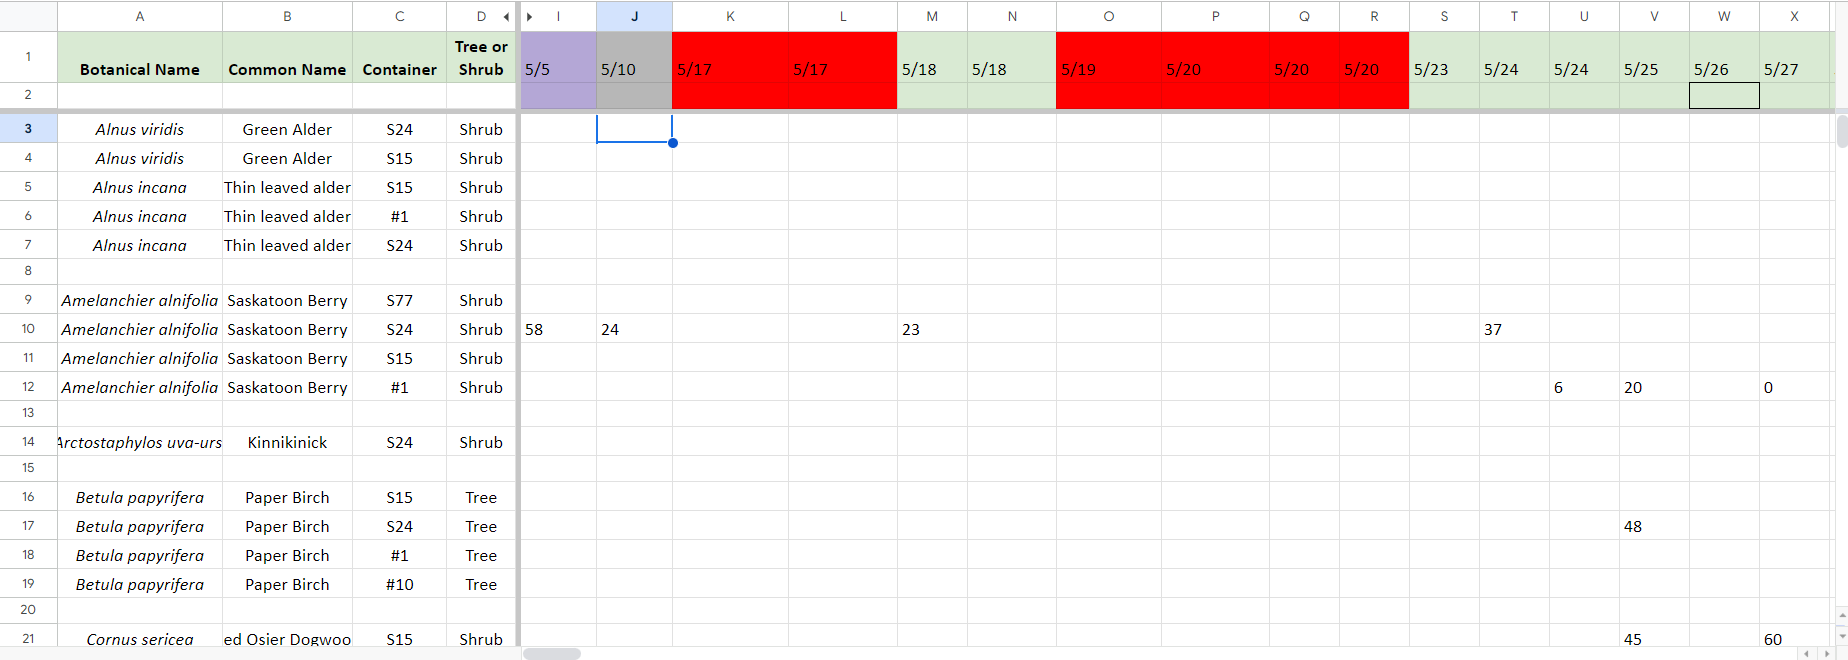

In order to make this usable for analysis, I had to transform it into a "tall" format.

### Step One: =concatenate()

The first step in this process was to combine the Latin and Common names of each species, because I only want to include one column for names in my array formula. I did this by creating a new column and using the function "=concatenate(A2:B2)", then using ctrl+d to apply this pattern down the entire column.

### Step Two: Mapping

I took some time to visualize the final format that I wanted this data to be in, and realized that I wanted discrete columns for date, location, species name (combined), classification (tree or shrub) and quantity planted. The problem is that the inventory.xlsx sheet contains rows as well as columns that I need to make into discrete columns.

### Step Three: Onion Method

Specifically, I needed the row containing dates to be transformed into a column without losing their corresponding values. First, I tried performing this using =transpose() on row 1 and realized that this would not be sufficient, because this would not retain the relationship between the date, species, and quantity that I needed. This made me realize that I needed to flatten all of the values that I wanted to produce, including quantities, so that each would be stored in a discrete column. I also needed to do this across a variety of ranges so that the relationships between fields were maintained, and to save time - I did not want to type a separate =flatten() formula for each range.

This led me to use an array formula with a special delimiter to produce all of my arrays at one time. 

### Step Four: =arrayformula()

My final array formula took the following form, using | as a delimiter: **=arrayformula(split(flatten(I1:JK1&"|"&C3:C159&"|"&D3:D159&"|"&I3:JK159), "|"))** where the first array contains the dates, the second contains the species name, the third contains classifications, and the fifth contains planting values. 

### Step Five: Failure

This array formula produced exactly what I wanted, but I soon found that the quantity of planting records contained in this dataset was far higher than what my own records reflected. This means that the dataset contains manual errors made while copying and pasting values into the spreadsheet. We won't be doing things this way in the future! But for now, I need to find a way to get more accurate values.

# Project Two

All of the program's planting records should be stored on individual spreadsheets called "Plant Trackers" that field staff fill out and submit at the end of each day. A blank copy of one is available in the data for this notebook. To minimize the chance of discrepancies due to human error, I decided to find a way to scrape all of the planting data directly from these documents, instead of relying on any manually-entered numbers that have been copied and pasted into different places.

### Step One: Collect Sheets

I desperately wanted to find a way to use Google Appscript to iterate over each one of these sheets separately and return the results I wanted. However, I learned that Appscript cannot programmatically access, for example, every separate file in a given folder.

As a result, I had to manually copy each one of these sheets to a destination sheet, using the "Copy To" feature.


### Step Two: Scraping

In order to get the planting data for each event that occurred in 2023, I had to write a program that would find and save these values in a separate sheet in the same workbook. 

The following Appscript function is what I came up with:

https://script.google.com/d/1y0ZM9s8IZzn9h6vD3_at_ECM6dmwSLNMt9XFi6bPXqmpJgMdXJH7L6jY/edit?usp=sharing

*(I chose to include a link to this script because of the difficulty of displaying it in Markdown.)*

This function iterates over each sheet, and returns the values of the cells that contain the date, location, species, and planted quantity of each species, under the condition that neither the "Planted" or "Species" columns are empty. This condition is needed because the original spreadsheets contain summary and other information beneath the values that I need, and I don't want these values being counted and input into my new spreadsheet. This allowed me to avoid any summary values that would inflate the results.

This function produced values in a separate tab called "ResultSheet", that looked like this:

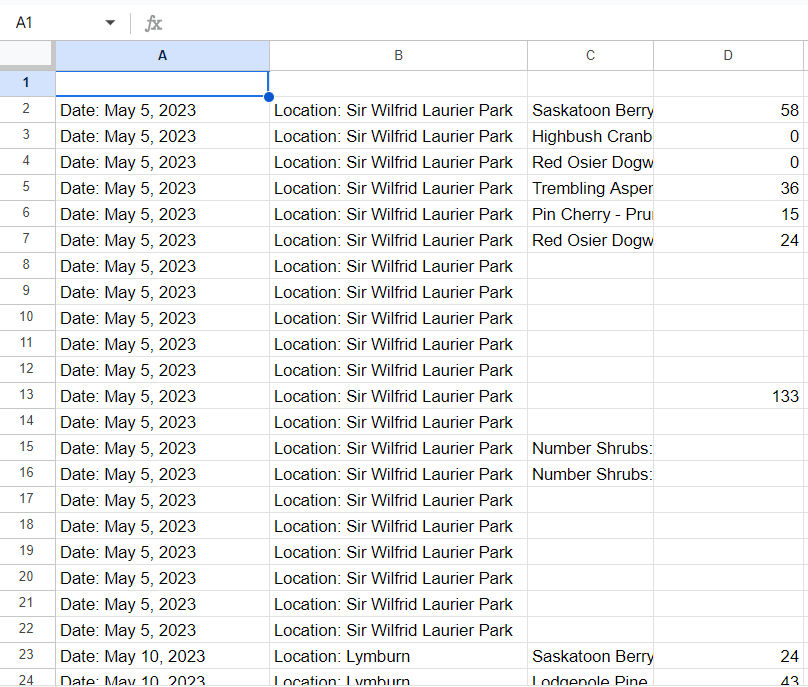




### Step Three: Cleaning and Formatting

In the above image, you can see that my function actually did return the summary data that I wanted it to avoid (the 133 with no corresponding species). This doesn't matter, though, since I can just filter out any values saved in column D that have null values in column C, and vice versa. 

My first cleaning step is to eliminate the "Date" and "Location" prefixes from the first two columns, and validate the format of the Date column. I did this by entering **=arrayformula(split(A2:A, ": ", False))** in a new column, and **=arrayformula(split(B2:B, ":"))** in another separate column. I also used **=split(C2:C, " - ")** to divide species into Common and Latin names, because my colleagues needed only the Latin names for reports, and this would allow me to see and correct and missing values. Finally, I highlighted the Date column (F) and changed the format to "Date" using the Format menu. This produced the following results:

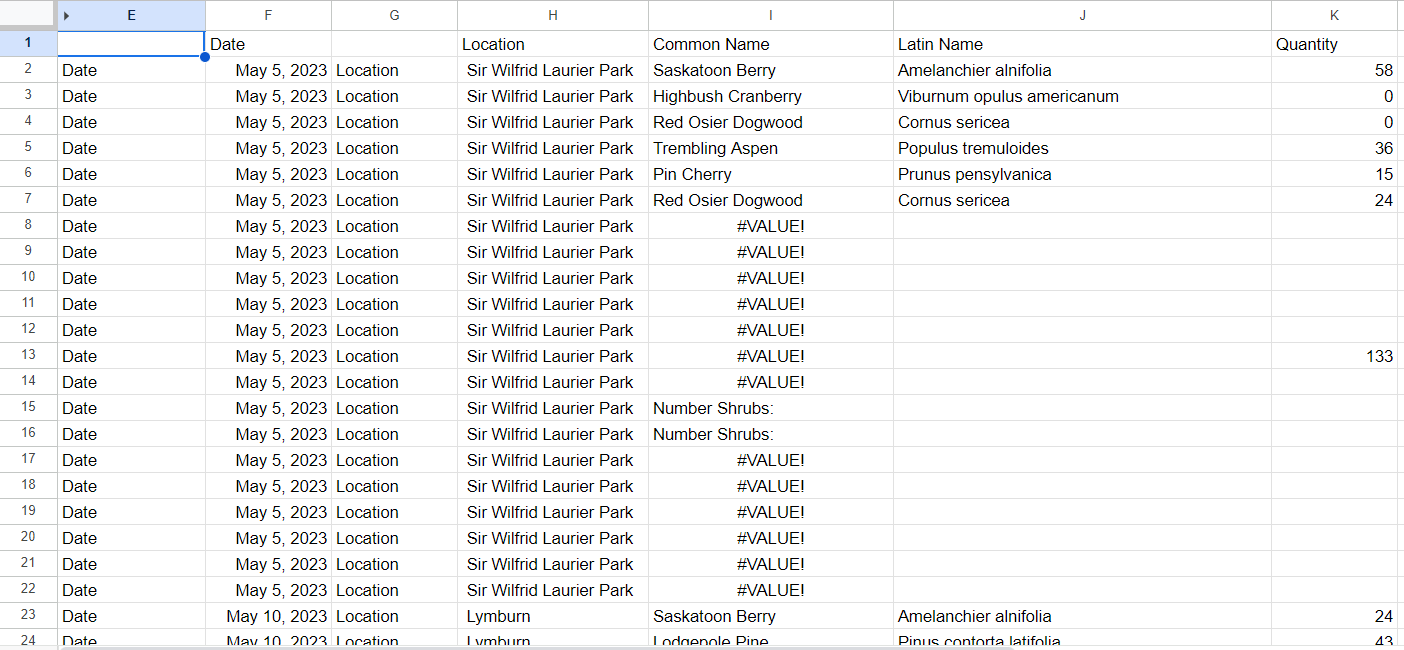



After this step, I used filters to remove any #VALUE! errors and non-plant-name values (like "Number Shrubs") in column I.

It was imperative that A. all of the species names were spelled correctly, B. all entries contained both Common Names and Latin Name values, and C. location names were kept consistent.

#### A
To fix mispelled and missing species names, I created a list of all common and Latin names, starting with column T in my "Clean" sheet, using the **=unique()** function on columns I and J above. I removed spelling mistakes, and then used the results of the =unique function to create a named range for data validation called "species" across both the Common and Latin name lists (columns T and and U on my "Clean" sheet).

#### B
Then, to ensure accuracy for the Latin Name column, I used the function **=IF(T2="", "", VLOOKUP(T2, species, 2, FALSE)).** This populates the Latin Name column based on the value in the Common Name column, which avoids any inconsistencies in the final product.

I filtered the Common Name and Latin Name columns for errors, and manually corrected any remaining data validation errors in the Common Name values. 

#### C
Finally, I created a list of unique location names using the **=unique()** function, removed any spelling mistakes or unwanted idiosyncracies, and labelled this as a named range.

Many of the locations contain a suffix with directional coordinates (like "(NW)") in brackets. I removed these where they were present with the following formula that replaces the suffix with an empty string, and applied it to each cell in the column using ctrl+d:

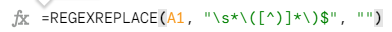

This left me with only a few validation errors, which I was able to correct manually. I have uploaded a raw version of the clean data to this notebook.

# Analysis and End Results
All of this cleaning left me with data in the following format:

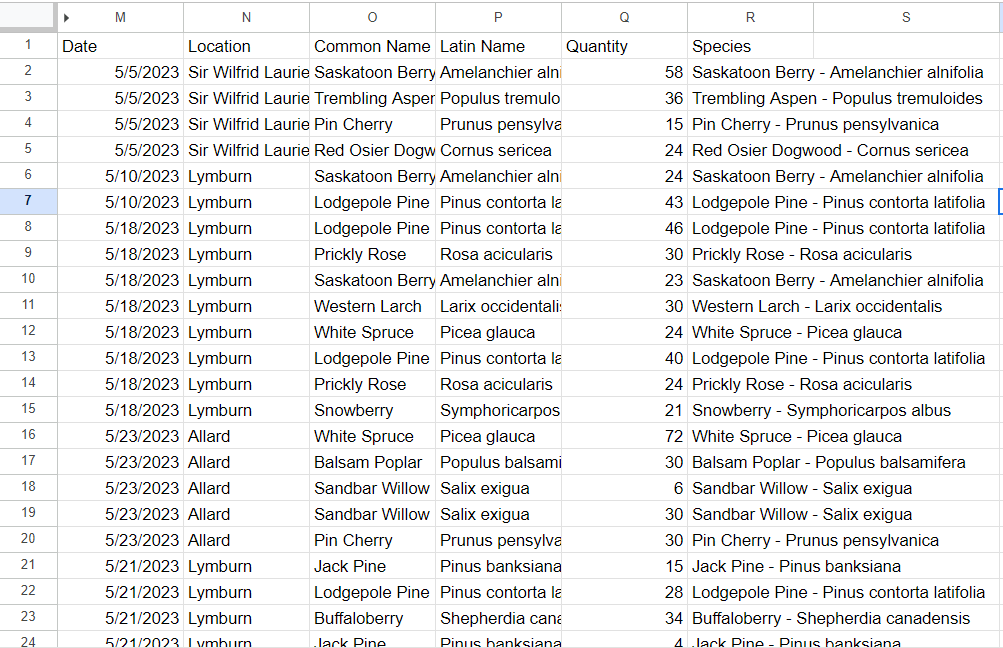

Since this contains consistent location and species names, I was able to produce the following pivot table by simply adding Location and Latin Name as rows, and Quantity as a value:

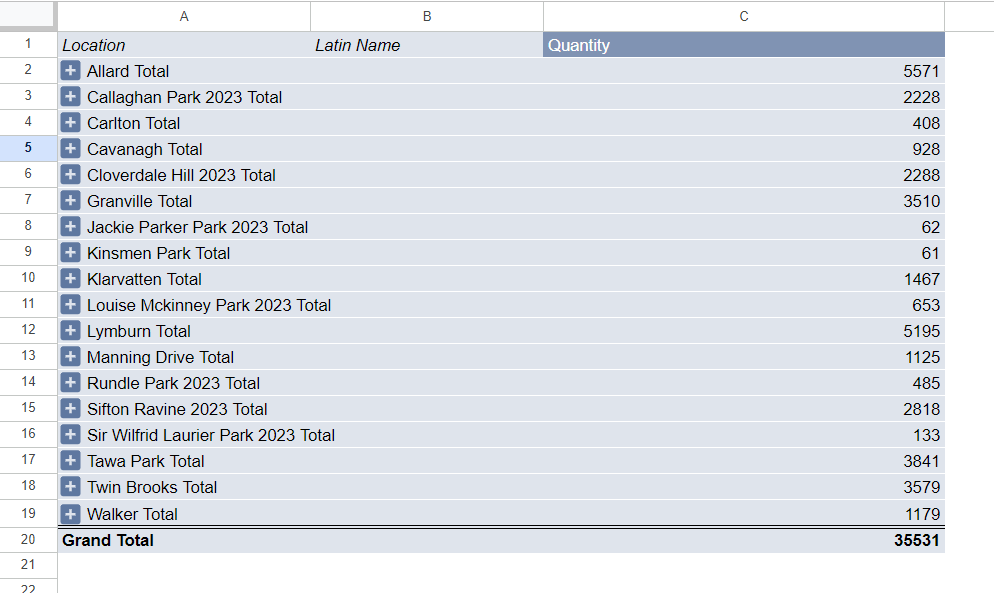



Latin names are listed as subvalues of each location:

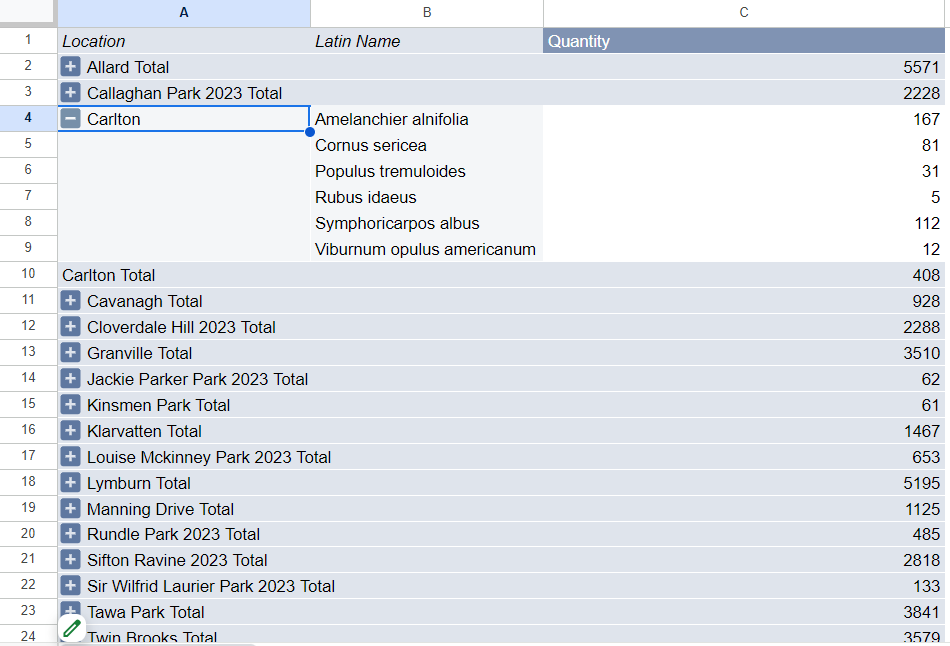

This pivot table allows me to produce simple charts, including this one: 

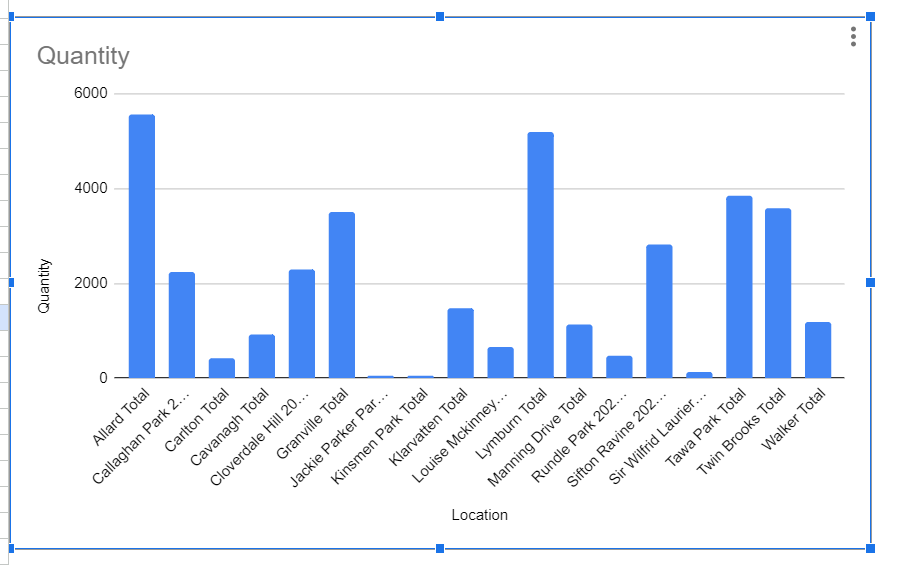

I also created the following chart using the Clean dataset:

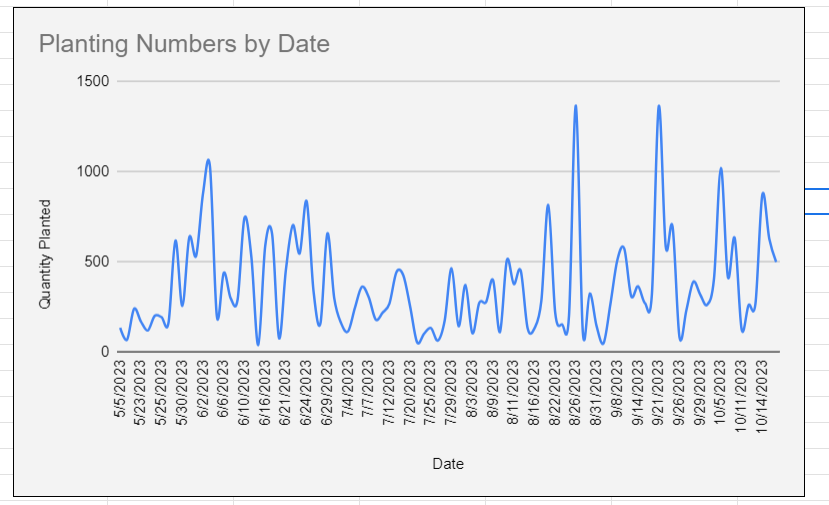

Next, I will use Google Looker to make an interactive Dashboard that incorporates Google Maps, as well as heatmap and line charts to demonstrate the most and least successful times of year for planting. The goal will be to demonstrate the effect of weather patterns on the program's planting activities.